Margaux Bailleul 21906121
Clémence CHESNAIS 21901191

# Import des modules

In [7]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import regex as re
from collections import defaultdict, Counter

# Pré-traitement des données

In [4]:
# import du fichier csv
data = pd.read_csv('french_books_reviews.csv', sep=',')
data.head()

,Unnamed: 0,book_title,author,reader_review,rating,label
0,0,Le Démon de la Colline aux Loups,Dimitri Rouchon-Borie,Ce n'est pas le premier roman à aborder les th...,5.0,1
1,1,Simple,Marie-Aude Murail,"Simple, alias Barnabé, est un jeune homme de 2...",4.0,1
2,2,La plus secrète mémoire des hommes,Mohamed Mbougar Sarr,Pour écrire La plus secrète mémoire des hommes...,4.0,1
3,3,Trancher,Amélie Cordonnier,« La violence d'Aurélien est revenue. Par la f...,3.5,0
4,4,"La guerre d'Alan, tome 2",Emmanuel Guibert,"Dans ce second album de La Guerre d’Alan, Emma...",5.0,1


Dans ce jeu de données nous disposons de 3 variables qualitatives et 2 variables quantitatives. 

Pour notre étude, nous avons le titre du livre, l'auteur, l'avis du lecteur, la note qu'il a attribué au livre ainsi qu'un label correspondant à la polarité de l'avis. Si l'avis est positif, le label vaut 1, s'il est neutre, il vaut 0 et s'il est négatif, il vaut -1.

In [10]:
data["label"].value_counts()

polarity_distribution= (pd.DataFrame.from_dict(Counter(data.label.values),
                                             orient='index')
                                  .rename(columns={0: 'nb_reviews'}))
polarity_distribution.index.name = 'class'
polarity_distribution

,nb_reviews
class,
1,6670
0,2129
-1,859


Dans ce jeu de données, il y a 6670 positifs, 2129 neutres et 859 négatifs.

Nous calculons le pourcentage d'avis pour chaque polarité.

In [14]:
polarity_distribution['pourcentage'] = np.around(polarity_distribution.nb_reviews /
                                                np.sum(polarity_distribution.nb_reviews),
                                                2)
polarity_distribution

,nb_reviews,pourcentage
class,,
1,6670,0.69
0,2129,0.22
-1,859,0.09


Nous représentons sur un graphique la distributions des polarités selon le nombre d'avis de livre

<Axes: title={'center': 'Number of reviews per class'}, xlabel='class'>

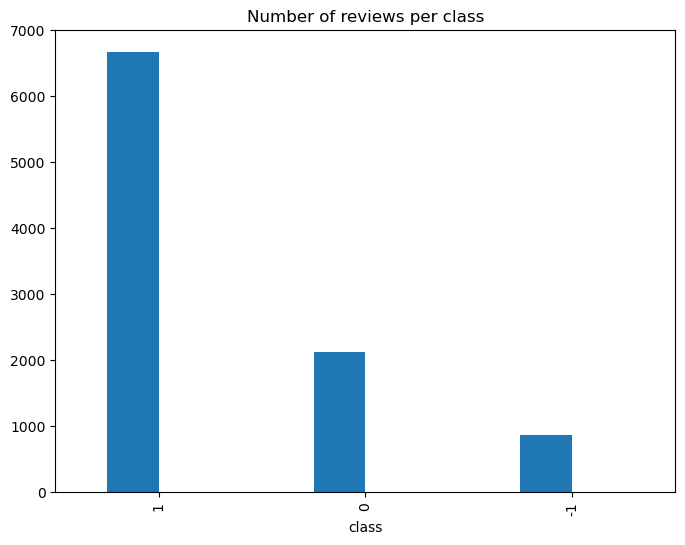

In [15]:
polarity_distribution.plot(kind='bar', figsize=(8, 6), legend=False, 
                           title="Nombre d'avis par classe")

### Affichage d'un avis

Nous affichons un avis pour voir à quoi ressemble les données.
